In [10]:
import gtfs_kit as gk
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from funcs import process_line, show_headways, compute_scheduled_headways
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read gtfs3Sept.zip
file3s = Path('./gtfs/gtfs3Sept.zip')
feed3s = (gk.read_feed(file3s, dist_units='m'))
feed3s.validate()

,type,message,table,rows
0,warning,Feed expired,calendar/calendar_dates,[]


In [3]:
# Read gtfs23Sept.zip
file23s = Path('./gtfs/gtfs23Sept.zip')
feed23s = (gk.read_feed(file23s, dist_units='m'))
feed23s.validate()

,type,message,table,rows
0,warning,Feed expired,calendar/calendar_dates,[]


In [4]:
# Our data goes from 2021-09-05 to 2021-09-21
print(gk.calendar.get_week(feed3s, 3))
print(gk.calendar.get_week(feed3s, 4))
print(gk.calendar.get_week(feed3s, 5))
print(gk.calendar.get_week(feed23s, 1)[:2])
print(gk.calendar.get_dates(feed3s))
# As we can see, we need both feeds to get the whole schedule, so we'll merge them

['20210906', '20210907', '20210908', '20210909', '20210910', '20210911', '20210912']
['20210913', '20210914', '20210915', '20210916', '20210917', '20210918', '20210919']
[]
['20210920', '20210921']
['20210823', '20210824', '20210825', '20210826', '20210827', '20210828', '20210829', '20210830', '20210831', '20210901', '20210902', '20210903', '20210904', '20210905', '20210906', '20210907', '20210908', '20210909', '20210910', '20210911', '20210912', '20210913', '20210914', '20210915', '20210916', '20210917', '20210918', '20210919']


In [8]:
# Get all dates matching our data
our_dates = {}
our_dates['3s'] = gk.calendar.get_week(feed3s, 3)
our_dates['3s'].extend(gk.calendar.get_week(feed3s, 4))
our_dates['23s'] = gk.calendar.get_week(feed23s, 1)[:2]
print(our_dates)

# Get all lines
lines = {}
lines['3s'] = gk.routes.get_routes(feed3s)
lines['23s'] = gk.routes.get_routes(feed23s)
print(lines['3s'].route_id.unique())

# Map each line to its short_name by joining route_id and route_short_name in routes.txt
short_names = {}
short_names['3s'] = gk.routes.get_routes(feed3s)[['route_id', 'route_short_name']].reset_index(drop=True)
short_names['23s'] = gk.routes.get_routes(feed23s)[['route_id', 'route_short_name']].reset_index(drop=True)

{'3s': ['20210906', '20210907', '20210908', '20210909', '20210910', '20210911', '20210912', '20210913', '20210914', '20210915', '20210916', '20210917', '20210918', '20210919'], '23s': ['20210920', '20210921']}
['2' '4' '5' '10' '1' '3' '6' '11' '12' '18' '20' '21' '22' '13' '23' '19'
 '25' '93' '27' '28' '29' '76' '32' '34' '35' '37' '39' '41' '43' '45'
 '36' '40' '44' '30' '47' '48' '49' '50' '15' '31' '52' '53' '26' '54'
 '55' '56' '57' '58' '59' '9' '60' '62' '63' '64' '17' '38' '65' '66' '98'
 '51' '68' '69' '70' '71' '72' '61' '42' '14' '16' '91' '73' '46' '89'
 '24' '74' '90' '33' '7' '75' '77' '8' '67' '95' '96' '97' '94' '78' '80'
 '79' '82' '81' '83' '85' '84' '86' '92' '87' '88']


In [12]:
for key in lines:
    rids = lines[key].route_id.unique()
    for rid in rids:
        for date in our_dates[key]:
            line = short_names['3s'].loc[short_names['3s'].route_id == rid].route_short_name.values[0]
            print(f'Processing line {line} on {date}...')
            # Get timetable for route_id rid and day date
            if key == '3s':
                timetable = process_line(feed3s, rid, [date])
            else:
                timetable = process_line(feed23s, rid, [date])
            # Save to csv
            timetable.to_csv(f'./schedules_day/schedule_{line}_{date}.csv')

Processing line 1 on 20210906...
Processing line 1 on 20210907...
Processing line 1 on 20210908...
Processing line 1 on 20210909...


KeyboardInterrupt: 

In [16]:
# read all schedules and merge them by line
schedules = {}
for key in lines:
    rids = lines[key].route_id.unique()
    for rid in rids:
        line = short_names['3s'].loc[short_names['3s'].route_id == rid].route_short_name.values[0]
        print(f'Reading line {line}...')
        for date in our_dates[key]:
            print(f'Reading schedule for {date}...')
            schedule = pd.read_csv(f'./schedules_day/schedule_{line}_{date}.csv', index_col=0)
            # Add date to schedule
            schedule['date'] = date
            if line in schedules:
                schedules[line] = pd.concat([schedules[line], schedule])
            else:
                schedules[line] = schedule
        # Save to csv
        schedules[line].to_csv(f'./schedules_line/schedule_{line}.csv')

Reading line 1...
Reading schedule for 20210906...
Reading schedule for 20210907...
Reading schedule for 20210908...
Reading line 2...
Reading schedule for 20210906...


FileNotFoundError: [Errno 2] No such file or directory: './schedules_day/schedule_2_20210906.csv'

/home/jose/Desktop/Lorenc1o-repos/DataMining_HackMyRide/schedule/funcs.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_timetable['stop_id'] = reduced_timetable['stop_id'].apply(lambda x: x[:-1] if x[-1].isalpha() else x)
/home/jose/Desktop/Lorenc1o-repos/DataMining_HackMyRide/schedule/funcs.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_timetable['headway'] = date_diff(series, series2)
/home/jose/Desktop/Lorenc1o-repos/DataMining_HackMyRide/schedule/funcs.py:82: SettingWithCopyWar

        trip_headsign  direction_id stop_id departure_time  headway  \
1449247         DELTA             0    1597       05:55:30        0   
1442407         DELTA             0    1597       06:15:30     1200   
1442668         DELTA             0    1597       06:30:30      900   
1443007         DELTA             0    1597       06:47:08      998   
1448969         DELTA             0    1597       06:56:08      540   
...               ...           ...     ...            ...      ...   
1444643  DE BROUCKERE             1    6447       23:31:00      660   
1445401  DE BROUCKERE             1    6447       23:43:00      720   
1448121  DE BROUCKERE             1    6447       23:55:00      720   
1446041  DE BROUCKERE             1    6447       24:07:00      720   
1443365  DE BROUCKERE             1    6447       24:19:00      720   

               class  
1449247  punctuality  
1442407  punctuality  
1442668  punctuality  
1443007  punctuality  
1448969   regularity  
...      

/home/jose/Desktop/Lorenc1o-repos/DataMining_HackMyRide/schedule/funcs.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['class'] = class_
/home/jose/Desktop/Lorenc1o-repos/DataMining_HackMyRide/schedule/funcs.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_timetable['headway'] = reduced_timetable['headway'].apply(lambda x: 0 if x < 0 else x)


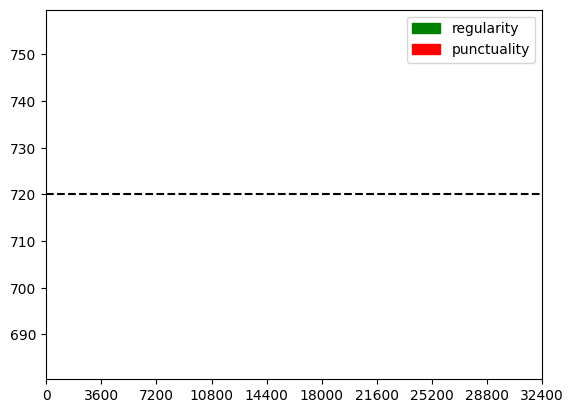

In [4]:
tt = process_line(feed3s, '65', ['20210906'])
print(tt)
# get some stop_id from the timetable
stop_id = tt.stop_id.unique()[0]
show_headways(stop_id, tt, direction_id=1)

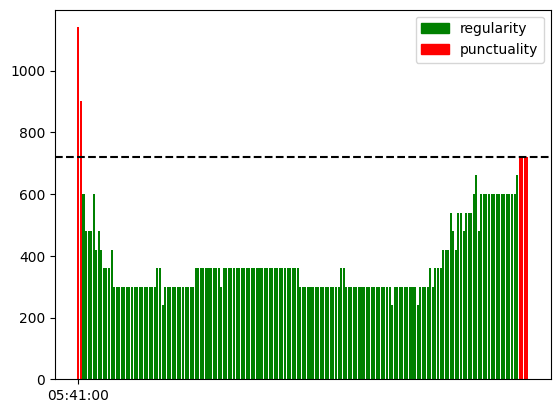

In [8]:
show_headways('2596', tt, direction_id=1) # 2296, 6444

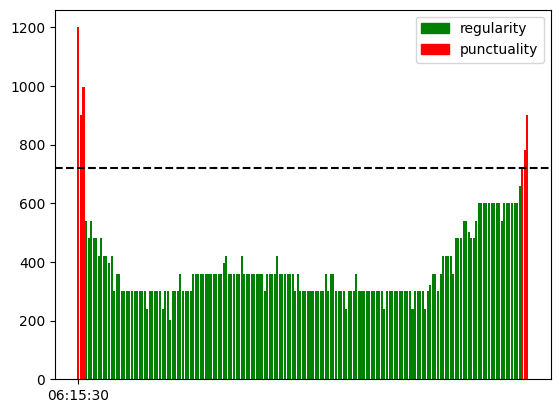

In [9]:
show_headways('1597', tt, direction_id=0)

In [10]:
print('going to delta:')
print(tt.loc[tt['direction_id']==1]['stop_id'].unique())
print('going to de broukere:')
print(tt.loc[tt['direction_id']==0]['stop_id'].unique())
print('all:')
print(tt.stop_id.unique())
print(tt.loc[tt['stop_id'] == '2720F'])
# save tt
# tt.to_csv('71_0911.csv')

going to delta:
['1598' '2301' '2351' '2595' '2596' '2948' '2963' '2964' '2967' '3521'
 '3525' '3556' '3557' '3558' '3559' '3562' '3567' '3570' '3572' '5612'
 '6447']
going to de broukere:
['1597' '1734' '2296' '2397' '2596' '2928' '3502' '3503' '3506' '3508'
 '3510' '3514' '3515' '3517' '3518' '3520' '5407' '5611' '6444']
all:
['1597' '1734' '2296' '2397' '2596' '2928' '3502' '3503' '3506' '3508'
 '3510' '3514' '3515' '3517' '3518' '3520' '5407' '5611' '6444' '1598'
 '2301' '2351' '2595' '2948' '2963' '2964' '2967' '3521' '3525' '3556'
 '3557' '3558' '3559' '3562' '3567' '3570' '3572' '5612' '6447']
Empty DataFrame
Columns: [trip_headsign, direction_id, stop_id, departure_time, headway, class]
Index: []


In [5]:
df = compute_scheduled_headways(tt)

/home/jose/Desktop/Lorenc1o-repos/DataMining_HackMyRide/schedule/funcs.py:182: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'stop_id': stop, 'direction_id': direction, 'interval_type':interval_type, 'interval_id': interval_id, 'interval_start': current_start, 'interval_end': current_end, 'avg_headway': avg_headway}, ignore_index=True)
/home/jose/Desktop/Lorenc1o-repos/DataMining_HackMyRide/schedule/funcs.py:157: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'stop_id': stop, 'direction_id':direction, 'interval_type':interval_type, 'interval_id': interval_id, 'interval_start': current_start, 'interval_end': current_end, 'avg_headway': avg_headway}, ignore_index=True)
/home/jose/Desktop/Lorenc1o-repos/DataMining_HackMyRide/schedule/funcs.py:210: FutureWarning: The frame.append meth

In [6]:
print(df)
# save df
df.to_csv('71_0911_headways.csv')

    stop_id direction_id interval_id interval_start interval_end  avg_headway  \
0      1597            0           0       05:55:30     06:47:08   774.500000   
1      1597            0           1       06:56:08     24:22:30   370.304094   
2      1597            0           2       24:34:30     25:02:30   800.000000   
3      1597            1           0       24:19:00     24:19:00   720.000000   
4      1734            0           0       05:37:00     06:26:00   735.000000   
..      ...          ...         ...            ...          ...          ...   
163    5612            1           2       23:33:07     24:09:07   720.000000   
164    6447            0           0       24:19:00     24:19:00   720.000000   
165    6447            1           0       05:18:00     05:52:00   680.000000   
166    6447            1           1       06:02:00     23:31:00   371.578947   
167    6447            1           2       23:43:00     24:19:00   720.000000   

    interval_type  
0     p